# PROYECTO FINAL

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [125]:
# Tratamiento de datos
import numpy as np
import pandas as pd
import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp # chi square

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

In [4]:
df_bike = pd.read_csv("./bikes.csv", index_col=0)
df_bike.sample(6)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
563,564,18-07-2019,autumn,1,7,0,3,1,1,32.526653,37.27915,57.7083,9.208614,799,4914,5713
719,720,21-12-2019,spring,1,12,0,5,1,2,13.393347,15.08835,55.6667,25.083661,221,3402,3623
497,498,13-05-2019,summer,1,5,0,0,0,1,25.112500,29.26190,57.6250,15.082839,2172,3946,6118
348,349,15-12-2018,winter,0,12,0,4,1,2,17.322500,20.61185,63.4167,17.958814,181,3528,3709
181,182,01-07-2018,autumn,0,7,0,5,1,1,29.622500,32.60810,39.6250,6.874736,1246,4116,5362
614,615,07-09-2019,autumn,1,9,0,5,1,1,28.836653,32.86020,73.6250,11.500282,1045,6459,7504


---------

In [5]:
df_bike.stb.counts().T

,yr,holiday,workingday,weathersit,season,weekday,mnth,temp,hum,casual,windspeed,registered,atemp,cnt,instant,dteday
count,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730
unique,2,2,2,3,4,7,12,498,594,605,649,678,689,695,730,730
most_freq,0,0,1,1,autumn,6,1,26.035,61.3333,120,9.041918,4841,32.7344,5409,1,01-01-2018
most_freq_count,365,709,499,463,188,105,62,5,4,4,3,3,4,2,1,1
least_freq,0,1,0,3,winter,3,2,10.865,79.7083,2290,4.417256,3100,26.3571,5740,1,01-01-2018
least_freq_count,365,21,231,21,178,103,56,1,1,1,1,1,1,1,1,1


In [6]:
df_bike.describe()

,instant,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [7]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(2)
memory usage: 97.0+ KB


> - <font color = violet> NO TENEMOS NULOS
> -  730 filas
> - 17 columnas
- **Holiday** : 1 = festivo / 0 = no festivo
- **Weekday** = 0 Domingo - 6 Sábado
- **Workingday** = 1 laborable / 0 finde
- **Weathersit** = grados en el readme
- **Temperatura** = 
- **Humedad** =
- **Viento** = 
- **Casual** = nº de usuarios no registrados/día
- **Registered** = nº de usuarios registrados/día
- **Total** = total de usuarios/día



# REVISIÓN DE COLUMNAS:

### 1. FECHA:
- Tenemos "yr" (año) y "mnth" (mes) y obtenemos "day" a través de la separación de "dteday", que posteriormente eliminaremos:

In [8]:
df_bike["day"] = df_bike["dteday"].str.split(pat= "-", n = -1, expand = True)[0]

In [9]:
df_bike=df_bike.reindex(columns=['instant', 'dteday', 'season', 'yr', 'mnth','day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'])

------

### 2. Columna "season"
- Corregir de acuerdo con las fechas.

In [10]:
df_bike['dteday'] = df_bike['dteday'].apply(pd.to_datetime)

In [11]:
def meses(x):
    a = x.month

    if  a >= 1 and a<=3:
        return 'winter'
    elif a >= 4 and a<=6:
        return 'spring'
    elif a >= 7 and a<=9:
        return 'summer'
    else:
        return 'autumn'

In [12]:
df_bike['season'] = df_bike['dteday'].apply(meses)

In [13]:
df_bike.sample(5)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
510,511,2019-05-26,spring,1,5,26,0,6,0,1,28.392500,32.13480,73.2500,13.332464,2855,3681,6536
557,558,2019-12-07,autumn,1,7,12,0,4,1,1,29.349153,32.73415,52.9583,9.833925,1032,6414,7446
588,589,2019-12-08,autumn,1,8,12,0,0,0,1,28.734153,32.22895,53.0417,8.208304,2182,4362,6544
204,205,2018-07-24,summer,0,7,24,0,0,0,1,34.030000,39.74145,55.0833,11.334457,1050,2556,3606
240,241,2018-08-29,summer,0,8,29,0,1,1,1,26.103347,30.39790,55.4583,10.708275,729,3905,4634


 - Antes de codificarla hacemos una gráfica para ver cómo se reparte el alquiler de bicicletas durante las estaciones.

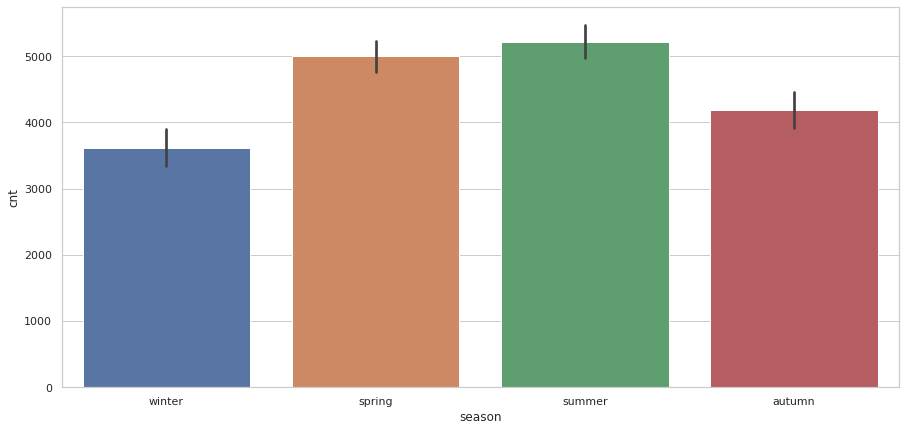

In [14]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
ax = sns.barplot(x = "season", y="cnt", data= df_bike)

 - Encoding numérico para la columna season

In [15]:
scale_mapper = {"winter":1, "spring":1, "summer":2, 'autumn':3}

df_bike['season_encoding'] = df_bike["season"].replace(scale_mapper)

- Hacemos una pequeña exploración preliminar con "season": ¿Cuántas reservas se hacen por estación y por tipo de cliente?

In [16]:
x= df_bike.groupby(['season']).agg({'cnt': ['sum'],'casual': ['sum'],'registered': ['sum']}).stb.subtotal()
x

,cnt,casual,registered
,sum,sum,sum
season,,,
autumn,771700,128069,643631
spring,909613,192850,716763
summer,958925,187579,771346
winter,650607,111454,539153
grand_total,3290845,619952,2670893


<AxesSubplot:xlabel='registered', ylabel='season'>

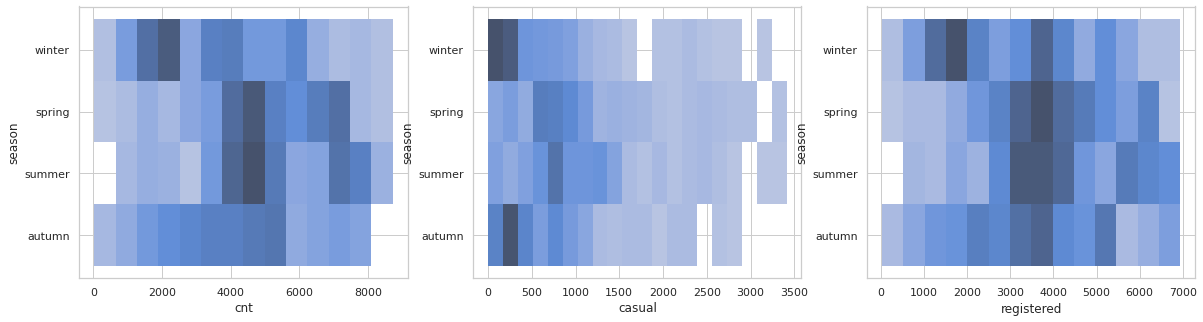

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(data=df_bike, x="cnt",y="season",ax=axes[0])
sns.histplot(data=df_bike, x="casual",y="season",ax=axes[1])
sns.histplot(data=df_bike, x="registered",y="season",ax=axes[2])

#HAY MAS RESERVAS DE GENTE REGISTRADA QUE CASUAL

--------

### 3. Columna "year" 

([<matplotlib.axis.XTick at 0x7f5c866655e0>,
 [Text(0, 0, '2018'), Text(1, 0, '2019')])

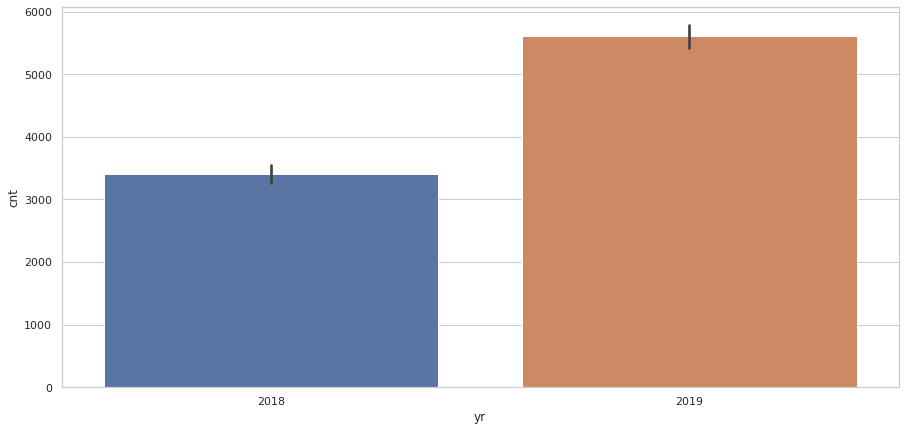

In [18]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
sns.barplot(x = "yr", y="cnt", data= df_bike)
plt.xticks([0, 1], ["2018", "2019"])

----

### 4. "Month" -> Exploración preliminar: reservas por mes.

<AxesSubplot:xlabel='mnth', ylabel='casual'>

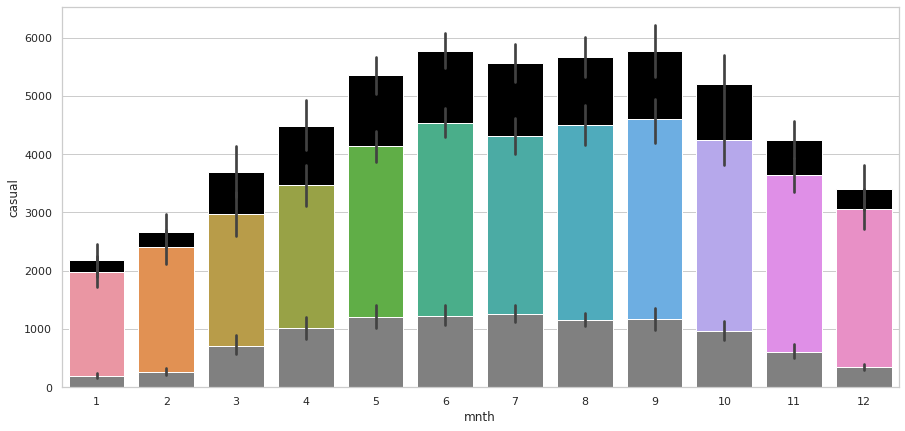

In [19]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
sns.barplot(x = "mnth", y ="cnt", data= df_bike, color = "black")

sns.barplot(x = "mnth", y="registered", data= df_bike)
sns.barplot(x = "mnth", y="casual", data= df_bike, color = "grey")
#plt.xticks([0, 1], ["2018", "2019"])

----

### 5. "Holiday"
1 = festivo /  0 = no festivo

df_bike.groupby(["holiday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)


Observamos: 
- Más reservas en NO FESTIVOS
- HAY MAYOR NUMERO DE RESERVAS LOS NO FESTIVOS
- Además:
    - SUMA EN NO FESTIVO
         - REGISTRADOS 2.614.817 RESERVAS EN NO FESTIVO
         - CASUAL 597.593 RESERVAS EN NO FESTIVO

    - SUMA EN FESTIVO
        - REGISTRADOS 56.076 RESERVAS EN  FESTIVO
        - CASUAL 22.359 RESERVAS EN NO FESTIVO

<AxesSubplot:xlabel='holiday', ylabel='count'>

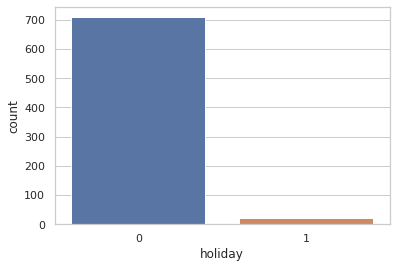

In [20]:
sns.countplot(x='holiday', data=df_bike)

-----

### 6. "Weekday" 
- 1-LUNES / 2-MARTES / 3-MIERCOLES / 4- JUEVES / 5-VIERNES / 6-SÁBADO / 0 -DOMINGO 

     Hay bastante igualdad entre los dias de la semana, siendo el ranking de más a menos reservas:
     ORDEN DE DIAS POR RESERVA: Viernes, jueves,sabado, miercoles,martes,lunes y domingo.


In [21]:
df_bike.groupby(["weekday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)

cnt                      ... registered                     
                min      max        sum  ...        max        sum      mean
weekday                                  ...                                
0             605.0   8227.0   444027.0  ...     5657.0   303506.0   2890.53
1              22.0   7525.0   455503.0  ...     6435.0   384719.0   3663.99
2             683.0   7767.0   469109.0  ...     6697.0   411266.0   3954.48
3             441.0   8173.0   471214.0  ...     6946.0   413960.0   4019.03
4             431.0   7804.0   485395.0  ...     6781.0   423935.0   4076.30
5            1167.0   8362.0   487790.0  ...     6917.0   409552.0   3938.00
6             627.0   8714.0   477807.0  ...     5966.0   323955.0   3085.29
grand_total  3976.0  56572.0  3290845.0  ...    45399.0  2670893.0  25627.62

[8 rows x 12 columns]

<AxesSubplot:xlabel='weekday', ylabel='registered'>

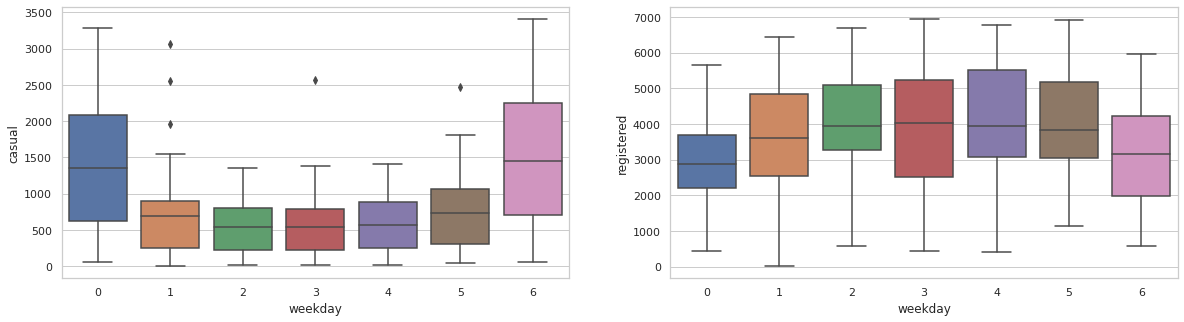

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(data=df_bike, x='weekday', y='casual',ax=axes[0])
sns.boxplot(data=df_bike, x='weekday', y='registered',ax=axes[1])

----

### 7. "workingday": 
- 1 - LABORABLE  /  0 -FIN DE SEMANA

In [23]:
df_bike.groupby(["workingday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)
# 1 dia laborable - hay muchas mas reservas en días laborables que festivos, más de el doble.

cnt                      ... registered                    
               min      max        sum  ...        max        sum     mean
workingday                              ...                               
0            605.0   8714.0  1000269.0  ...     5966.0   683537.0  2959.03
1             22.0   8362.0  2290576.0  ...     6946.0  1987356.0  3982.68
grand_total  627.0  17076.0  3290845.0  ...    12912.0  2670893.0  6941.71

[3 rows x 12 columns]

---

### 8. "weathersit": 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [24]:
weather = pd.DataFrame(df_bike[["cnt", "weathersit"]].groupby("weathersit"))

In [25]:
i = 0
lista2 = []
for i in range(len(df_bike["weathersit"].value_counts())):
    a = weather[1][i]["cnt"].sum()
    i = i+1
    lista2.append(a)

In [26]:
weathersit = pd.DataFrame(lista2)
weathersit["%"] = weathersit[0].apply(lambda x: x / df_bike.shape[0] * 100)
weathersit["Tipo"] = ["1", "2", "3"]

In [27]:
labelsX = ["1: Clear, Few clouds, Partly cloudy, Partly cloudy", "2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist", "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"]


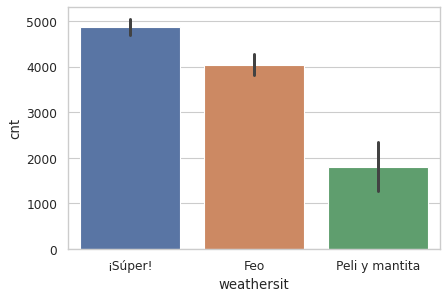

In [28]:
plt.figure(figsize=(6,4), dpi= 80)

sns.barplot(x = "weathersit", y = "cnt", data = df_bike)
plt.xticks([0, 1, 2], ["¡Súper!", "Feo", "Peli y mantita"]);


---

### 9. Temperatura, Sensación Térmica y Humedad

hay que hacer encoding con etiquetas para las graficas

In [29]:
df_bike.head(2)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1


In [30]:
df_bike[['temp','atemp','hum']] = df_bike[['temp','atemp','hum']].round(1)

In [31]:
df_temp = df_bike[['temp','atemp']]
df_temp

,temp,atemp
0,14.1,18.2
1,14.9,17.7
2,8.1,9.5
3,8.2,10.6
4,9.3,11.5
...,...,...
725,10.4,11.3
726,10.4,12.8
727,10.4,12.1
728,10.5,11.6


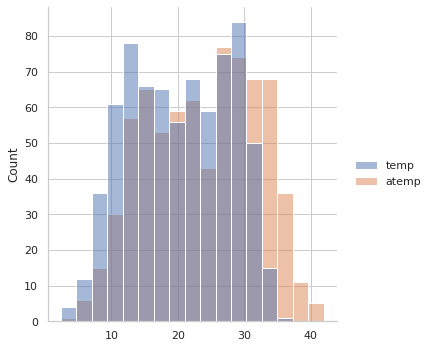

In [32]:
sns.displot(df_temp)

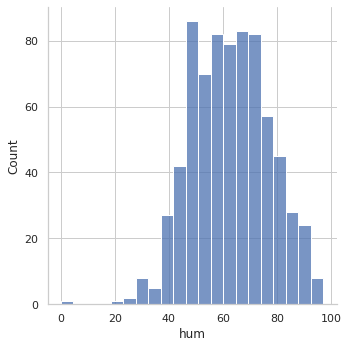

In [33]:
sns.displot(df_bike["hum"])

In [34]:
df_clima = df_bike[['temp','atemp','hum']]

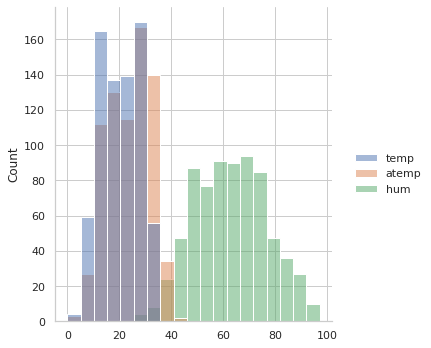

In [35]:
sns.displot(df_clima)

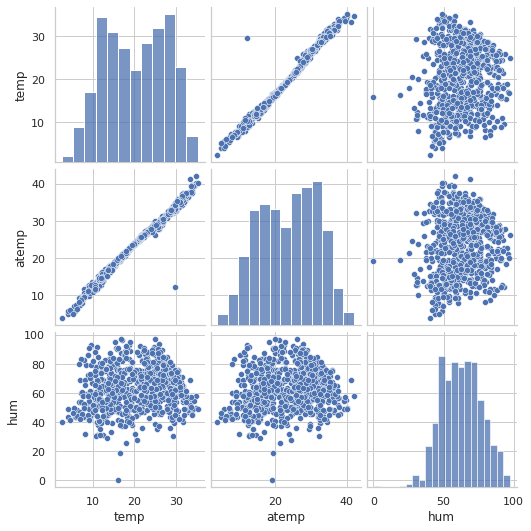

In [36]:
sns.pairplot(df_clima);

Voy a ver normalidad numéricamente

In [37]:
stats.shapiro(df_bike["atemp"])

ShapiroResult(statistic=0.9737697243690491, pvalue=3.6718658669165904e-10)

In [38]:
stats.shapiro(df_bike["temp"])

ShapiroResult(statistic=0.9657878279685974, pvalue=4.954737575085799e-12)

In [39]:
stats.shapiro(df_bike["hum"])

ShapiroResult(statistic=0.9933574795722961, pvalue=0.0025413876865059137)

Estas tres variables parecen normales

- Codificando variables

In [40]:
df_bike["temp_interval"] = pd.cut(df_bike["temp"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [41]:
df_bike["temp_interval_num"] = pd.cut(df_bike["temp"], 5, ordered=True)

In [42]:
#df_bike["atemp_interval"] = pd.cut(df_bike["atemp"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [43]:
df_bike["hum_interval"] = pd.cut(df_bike["hum"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [44]:
df_bike["hum_interval_num"] = pd.cut(df_bike["hum"], 5, ordered=True)

In [45]:
df_bike.head(2)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]"
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]"


In [46]:
#df_interval = df_bike[["atemp_interval","temp_interval","hum_interval"]]
#df_interval

Voy a hacer un ordinal encoding

In [47]:
from sklearn.preprocessing import OrdinalEncoder
orden = ["very_low", "low", "medium", "high", "very_high"]

In [48]:
def ordinal_encoder(df, columna, orden_valores):
    
    # nos creamos un diccionario vacío para hacer el map después. 
    ordinal_dict = {}
    
    # iteramos por nuestra lista de valores usando el enumerate que recordamos nos devolvía también el índice o posición de cada elemento
    for i, valor in enumerate(orden_valores):
        ordinal_dict[valor]=i+1 # le sumamos uno a la posición para no tener valores de 0. 
    
    # aplicamos el map
    df[columna+"_ord"] = df[columna].map(ordinal_dict)
    return df

In [49]:
#ordinal_encoder(df_bike, "atemp_interval", orden)

In [50]:
ordinal_encoder(df_bike, "temp_interval", orden)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
2,3,2018-03-01,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1
3,4,2018-04-01,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1
4,5,2018-05-01,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,2019-12-27,autumn,1,12,27,0,4,1,2,10.4,11.3,65.3,23.458911,247,1867,2114,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
726,727,2019-12-28,autumn,1,12,28,0,5,1,2,10.4,12.8,59.0,10.416557,644,2451,3095,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
727,728,2019-12-29,autumn,1,12,29,0,6,0,2,10.4,12.1,75.3,8.333661,159,1182,1341,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
728,729,2019-12-30,autumn,1,12,30,0,0,0,1,10.5,11.6,48.3,23.500518,364,1432,1796,3,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2


In [51]:
ordinal_encoder(df_bike, "hum_interval", orden)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
2,3,2018-03-01,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1,3
3,4,2018-04-01,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1,4
4,5,2018-05-01,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,2019-12-27,autumn,1,12,27,0,4,1,2,10.4,11.3,65.3,23.458911,247,1867,2114,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
726,727,2019-12-28,autumn,1,12,28,0,5,1,2,10.4,12.8,59.0,10.416557,644,2451,3095,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
727,728,2019-12-29,autumn,1,12,29,0,6,0,2,10.4,12.1,75.3,8.333661,159,1182,1341,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
728,729,2019-12-30,autumn,1,12,30,0,0,0,1,10.5,11.6,48.3,23.500518,364,1432,1796,3,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3


- Saco gráficos

In [52]:
df_group_temp = df_bike.groupby(["temp_interval"]).agg({'cnt': ['sum']})

In [53]:
df_group_hum= df_bike.groupby(["hum_interval"]).agg({'cnt': ['sum']})
df_group_hum

,cnt
,sum
hum_interval,
very_low,2258
low,95327
medium,1224798
high,1595145
very_high,373317


Se acercan bastante a la normal.

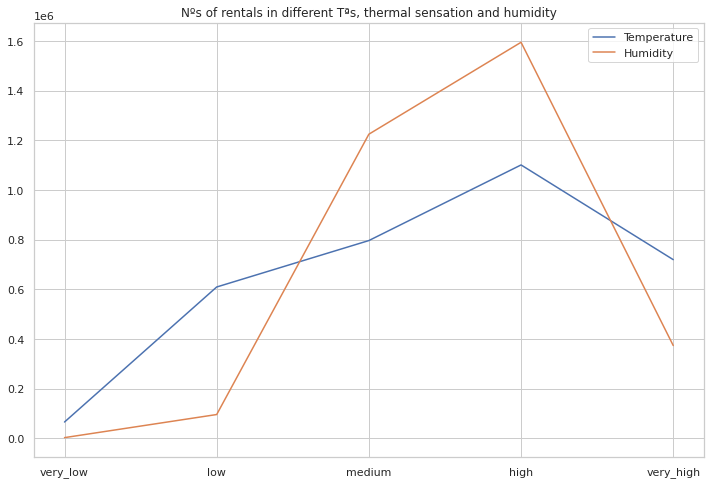

In [54]:
plt.figure(figsize=(12,8))
plt.plot(df_group_temp, label = "Temperature")
#plt.plot(df_group_atemp, label = "Thermal sensation")
plt.plot(df_group_hum, label = "Humidity")
plt.title("Nºs of rentals in different Tªs, thermal sensation and humidity")
plt.legend()
plt.show()

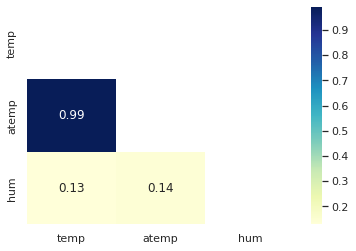

In [55]:
mask = np.triu(np.ones_like(df_clima.corr(), dtype=np.bool))
mask
sns.heatmap(df_clima.corr(),
            cmap = "YlGnBu", 
            mask = mask, # incorporamos la máscara en nuestro plot
           annot = True); 

---

### 10. "Windspeed": encoding

In [56]:
df_bike['wind_interval'] = pd.cut(df_bike['windspeed'], 5, labels=["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [57]:
df_bike['wind_interval'] = df_bike['wind_interval'].astype('object')

 - Al utilizar el método pd.cut nos devuelve una columna categórica, por eso lo cambiamos a tipo int64. Ahora ya tenemos codificada esta columna.

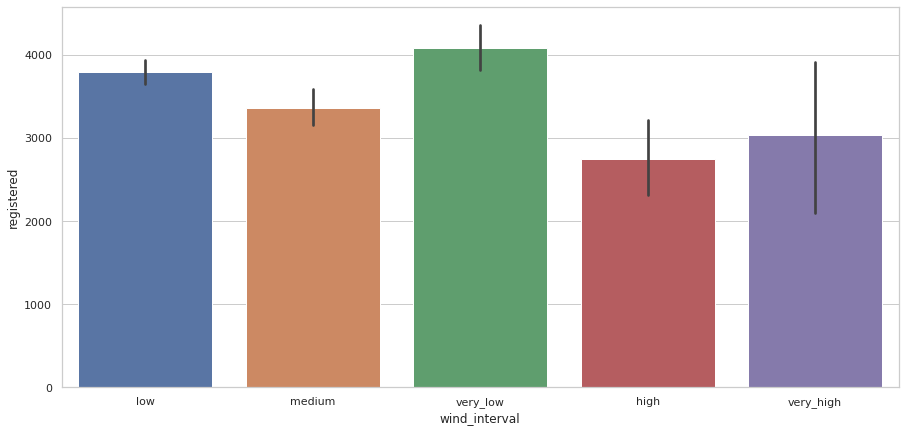

In [58]:
plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="wind_interval", y="registered", data=df_bike)

 - Encoding numérico para la columna wind

In [59]:
scale_mapper = {"very low":0, "low":1, "medium":2, 'high':3, 'very high':4}

df_bike['wind_num_encoding'] = df_bike["wind_interval"].replace(scale_mapper)

----

### Últimas columnas: bicis registradas
- cnt (total por día)
- registered (reservadas por usuarios registrados)
- casual (bicis alquiladas por usuarios casuales) 

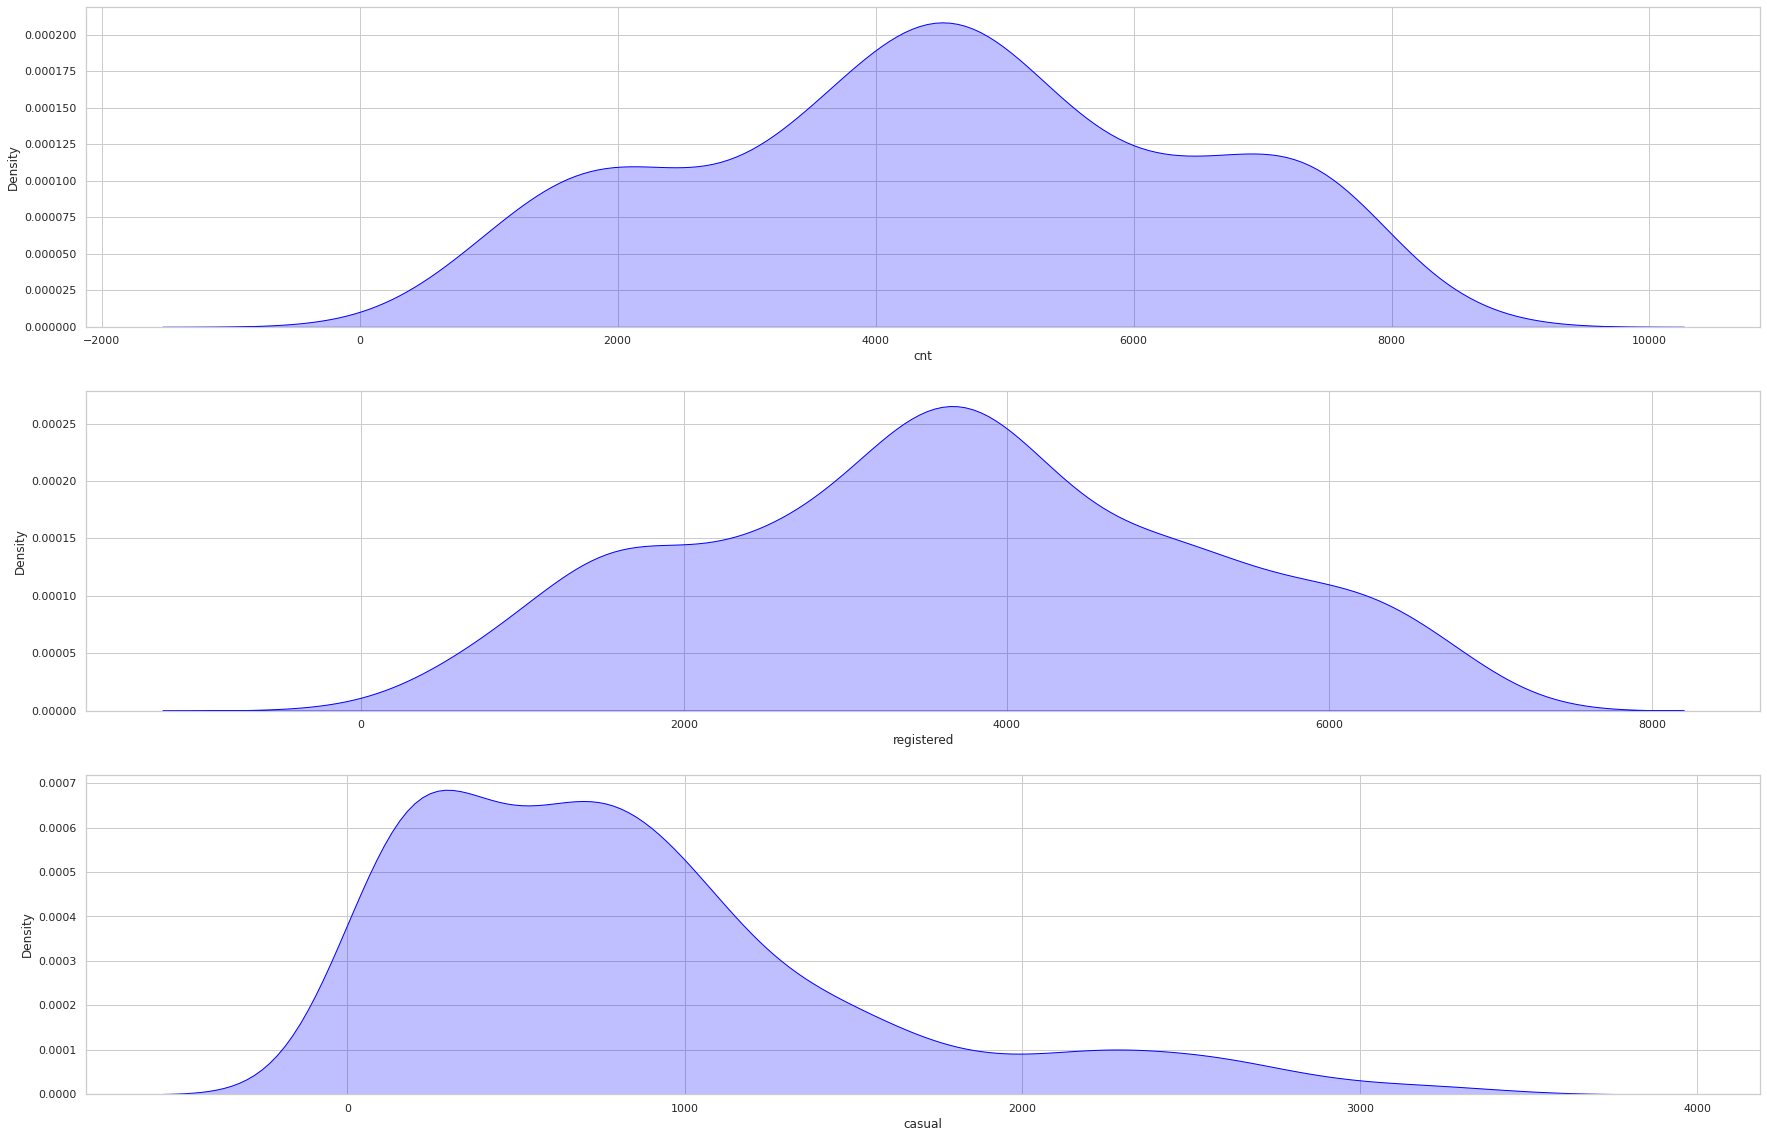

In [60]:
fig, axes= plt.subplots(3,1, figsize= (30, 20))
axes = axes.flat
sns.distplot(df_bike.cnt, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[0])
sns.distplot(df_bike.registered, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[1])
sns.distplot(df_bike.casual, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[2]);


-----

### ELIMINAMOS COLUMNAS SOBRANTES

Después de este proceso de exploración y limpieza decidimos borrar las columnas siguientes:
- Atemp (y sus derivadas) pues sus datos son muy similiares a los de temperatura. Usaremos esta segunda.
- "Dtday": pues ya hemos desglosado esa columna en día/mes/año
- "Instant": pues funciona como un índice, y usaremos el índice del dataframe

In [61]:
df_bike.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'day', 'holiday',
       'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'season_encoding',
       'temp_interval', 'temp_interval_num', 'hum_interval',
       'hum_interval_num', 'temp_interval_ord', 'hum_interval_ord',
       'wind_interval', 'wind_num_encoding'],
      dtype='object')

In [62]:
df_bike = df_bike.drop(columns= ['instant', 'dteday'], axis=1 )

In [63]:
df_bike.head()

,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord,wind_interval,wind_num_encoding
0,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5,low,1
1,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4,medium,2
2,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1,3,medium,2
3,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1,4,low,1
4,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3,low,1


### REORDENAMOS LAS COLUMNAS:

In [64]:
cols = ['season_encoding', 'season', 'yr', 'mnth', 'day', 'holiday', 'weekday', 'workingday',
                            'weathersit', 'temp', 'temp_interval', 'temp_interval_ord', "temp_interval_num", 'hum', 'hum_interval', 'hum_interval_num','hum_interval_ord', 'windspeed', 'wind_interval', 'wind_num_encoding','casual', 'registered', 'cnt']
len(cols) 

23

In [65]:
df_bike.head(2)

,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord,wind_interval,wind_num_encoding
0,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5,low,1
1,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4,medium,2


In [66]:
df_bike = df_bike.reindex(columns = cols)

# GUARDAMOS DATAFRAME FINAL

In [67]:
df_bike.to_csv("bikes_post_eda.csv")

------
------
----

# <font color = orange> SPRINT 2 - EMPIEZA LA REGRESIÓN

In [88]:
df = pd.read_csv("bikes_post_eda.csv", index_col = 0)
df.head()

,season_encoding,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,temp_interval_num,hum,hum_interval,hum_interval_num,hum_interval_ord,windspeed,wind_interval,wind_num_encoding,casual,registered,cnt
0,1,winter,0,1,1,0,6,0,2,14,low,2,"(8.98, 15.56]",81,very_high,"(77.76, 97.2]",5,11,low,1,331,654,985
1,1,winter,0,1,2,0,0,0,2,15,low,2,"(8.98, 15.56]",70,high,"(58.32, 77.76]",4,17,medium,2,131,670,801
2,1,winter,0,1,3,0,1,1,1,8,very_low,1,"(2.367, 8.98]",44,medium,"(38.88, 58.32]",3,17,medium,2,120,1229,1349
3,1,spring,0,1,4,0,2,1,1,8,very_low,1,"(2.367, 8.98]",59,high,"(58.32, 77.76]",4,11,low,1,108,1454,1562
4,1,spring,0,1,5,0,3,1,1,9,low,2,"(8.98, 15.56]",44,medium,"(38.88, 58.32]",3,13,low,1,82,1518,1600


# REALIZAMOS DATAFRAME CON VARIABLES PARA PROBAR REGRESIÓN: solo datos originales // solo encoding

In [69]:
df.head(2)

,season_encoding,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,temp_interval_num,hum,hum_interval,hum_interval_num,hum_interval_ord,windspeed,wind_interval,wind_num_encoding,casual,registered,cnt
0,1,winter,0,1,1,0,6,0,2,14.1,low,2,"(8.98, 15.56]",80.6,very_high,"(77.76, 97.2]",5,10.749882,low,1,331,654,985
1,1,winter,0,1,2,0,0,0,2,14.9,low,2,"(8.98, 15.56]",69.6,high,"(58.32, 77.76]",4,16.652113,medium,2,131,670,801


In [70]:
df_encoded = df[['season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp_interval_ord','hum_interval_ord', 'wind_num_encoding', 'casual', 'registered', 'cnt']] 

In [71]:
df_datos = df[['season', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', "hum", "windspeed", 'casual', 'registered', 'cnt']]

df_datos.head(2)

,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,winter,0,1,1,0,6,0,2,14.1,80.6,10.749882,331,654,985
1,winter,0,1,2,0,0,0,2,14.9,69.6,16.652113,131,670,801


In [72]:
df_num_datos = df_datos.select_dtypes(include = np.number)
df_num_datos

,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,0,1,1,0,6,0,2,14.1,80.6,10.749882,331,654,985
1,0,1,2,0,0,0,2,14.9,69.6,16.652113,131,670,801
2,0,1,3,0,1,1,1,8.1,43.7,16.636703,120,1229,1349
3,0,1,4,0,2,1,1,8.2,59.0,10.739832,108,1454,1562
4,0,1,5,0,3,1,1,9.3,43.7,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,12,27,0,4,1,2,10.4,65.3,23.458911,247,1867,2114
726,1,12,28,0,5,1,2,10.4,59.0,10.416557,644,2451,3095
727,1,12,29,0,6,0,2,10.4,75.3,8.333661,159,1182,1341
728,1,12,30,0,0,0,1,10.5,48.3,23.500518,364,1432,1796


# OUTLIERS

Hacer un describe

In [73]:
pd.set_option("display.float_format",lambda x: "%3.f" %x) #Usamos esta linea de código para que no aparezca los exponenciales
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season_encoding,730,2,1,1,1,2,3,3
yr,730,0,1,0,0,0,1,1
mnth,730,7,3,1,4,7,10,12
day,730,16,9,1,8,16,23,31
holiday,730,0,0,0,0,0,0,1
weekday,730,3,2,0,1,3,5,6
workingday,730,1,0,0,0,1,1,1
weathersit,730,1,1,1,1,1,2,3
temp,730,20,8,2,14,20,27,35
temp_interval_ord,730,3,1,1,2,3,4,5


In [74]:
pd.set_option("display.float_format",lambda x: "%3.f" %x) #Usamos esta linea de código para que no aparezca los exponenciales
df_num_datos.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,730,0,1,0,0,0,1,1
mnth,730,7,3,1,4,7,10,12
day,730,16,9,1,8,16,23,31
holiday,730,0,0,0,0,0,0,1
weekday,730,3,2,0,1,3,5,6
workingday,730,1,0,0,0,1,1,1
weathersit,730,1,1,1,1,1,2,3
temp,730,20,8,2,14,20,27,35
hum,730,63,14,0,52,63,73,97
windspeed,730,13,5,2,9,12,16,34


In [75]:
df_num_datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   mnth        730 non-null    int64  
 2   day         730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  casual      730 non-null    int64  
 11  registered  730 non-null    int64  
 12  cnt         730 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 79.8 KB


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_encoding    730 non-null    int64  
 1   season             730 non-null    object 
 2   yr                 730 non-null    int64  
 3   mnth               730 non-null    int64  
 4   day                730 non-null    int64  
 5   holiday            730 non-null    int64  
 6   weekday            730 non-null    int64  
 7   workingday         730 non-null    int64  
 8   weathersit         730 non-null    int64  
 9   temp               730 non-null    float64
 10  temp_interval      730 non-null    object 
 11  temp_interval_ord  730 non-null    int64  
 12  temp_interval_num  730 non-null    object 
 13  hum                730 non-null    float64
 14  hum_interval       730 non-null    object 
 15  hum_interval_num   730 non-null    object 
 16  hum_interval_ord   730 non

Tenemos outliers? ¿Que hacemos con ellos?

PRIMERO SELECCIONA LAS VARIABLES NUMÉRCIAS

In [77]:
df_numericas= df.select_dtypes(include="int64")

In [78]:
len(df_numericas.columns)

13

In [79]:
len(df_num_datos.columns)

13

BOXPLOT PARA VER 

<AxesSubplot:>

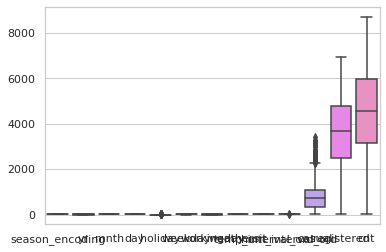

In [80]:
sns.boxplot(data = df_numericas)

<AxesSubplot:>

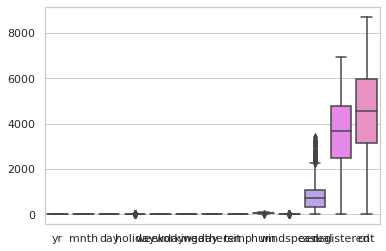

In [81]:
sns.boxplot(data=df_num_datos)

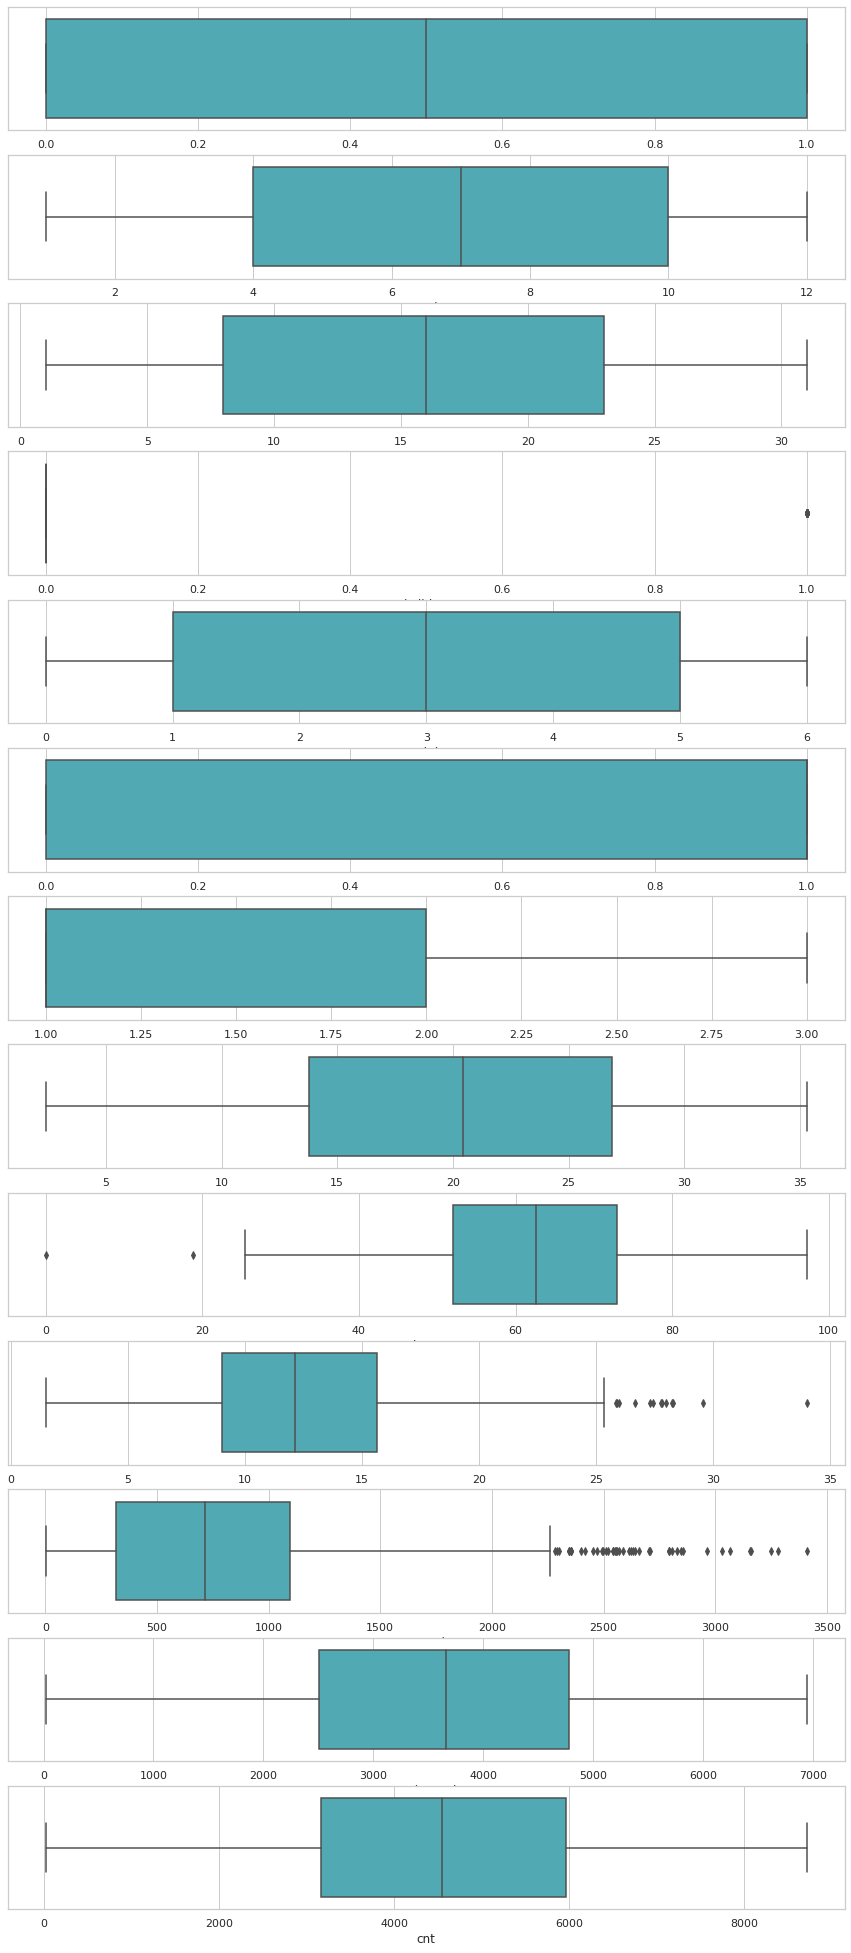

In [82]:
fig, axes = plt.subplots(13, 1, figsize=(15,35))
for i in range(len(df_num_datos.columns)):
    sns.boxplot(x = df_num_datos.columns[i], data = df,palette= "YlGnBu", ax=axes[i]); # para trazar una línea de densidad

plt.show()

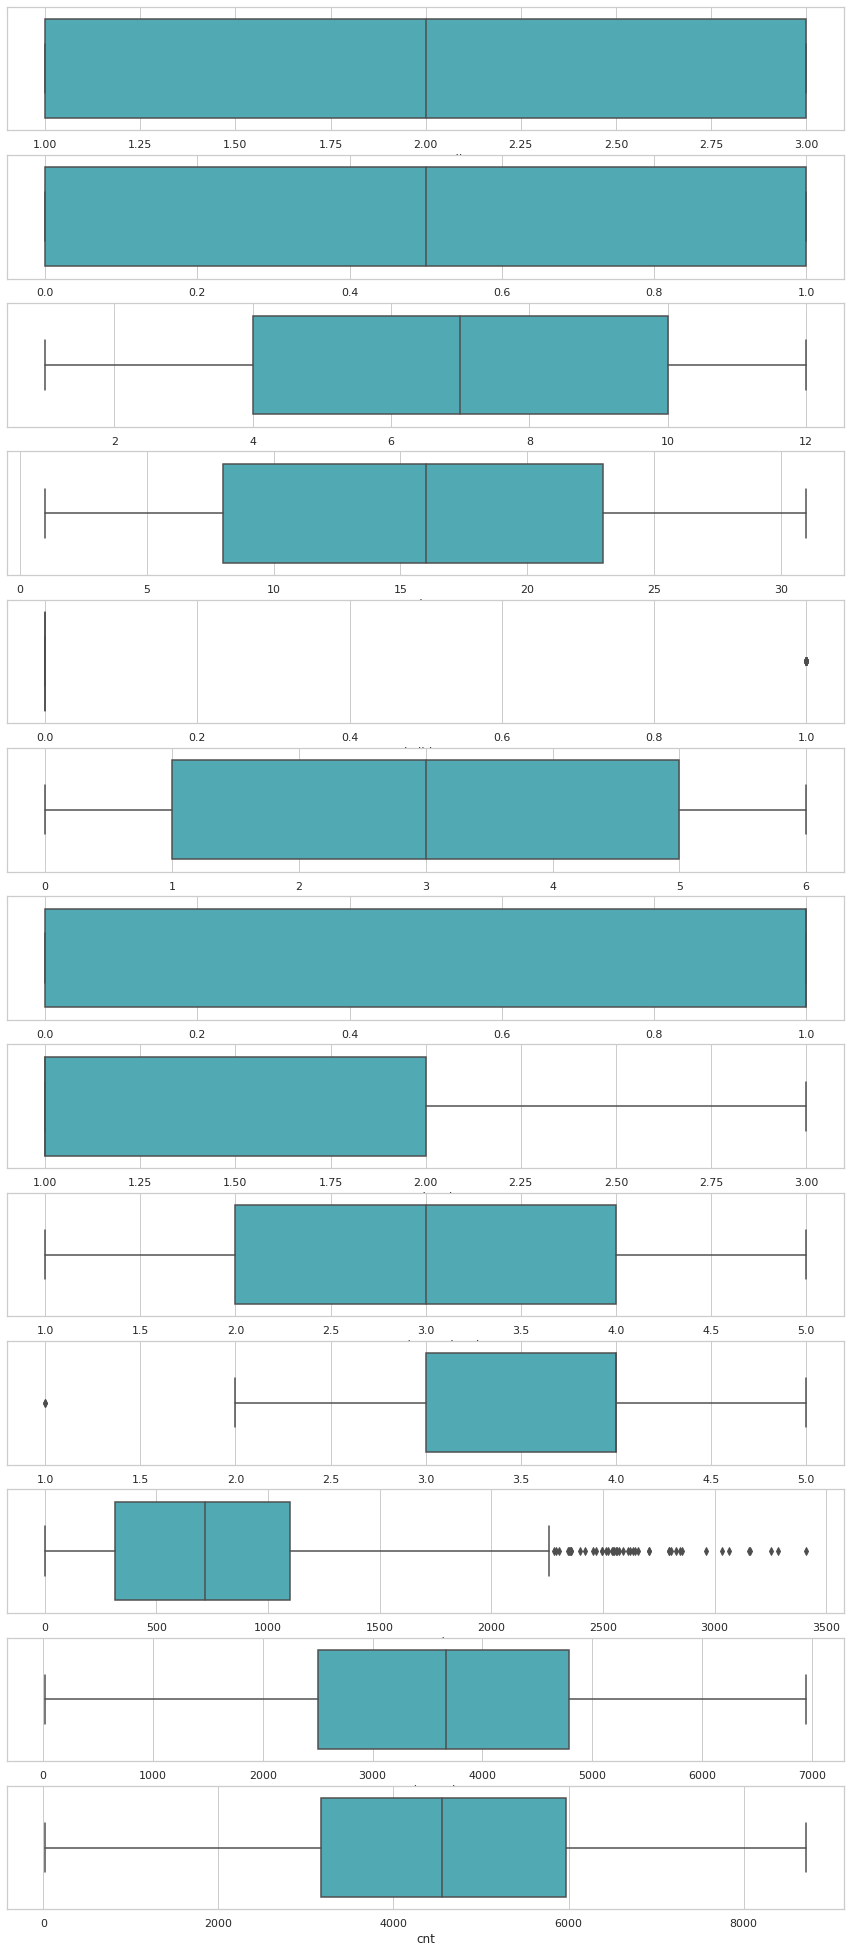

In [83]:
fig, axes = plt.subplots(13, 1, figsize=(15,35))
for i in range(len(df_numericas.columns)):
    sns.boxplot(x = df_numericas.columns[i], data = df,palette= "YlGnBu", ax=axes[i]); # para trazar una línea de densidad

plt.show()

VOY A DETECTAR LOS OUTLIERS

In [84]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} 
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    
    return dicc_indices 

In [85]:
lista_columnas = list(df_num_datos.columns)
ind = detectar_outliers(lista_columnas, df_num_datos)
print(ind)
for k, v in ind.items():
    mediana = df[k].median() 
    for i in v: 
        df.loc[i,k] = mediana

{'holiday': [16, 51, 104, 149, 184, 247, 282, 314, 327, 359, 366, 380, 415, 470, 512, 549, 610, 645, 680, 690, 723], 'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720], 'casual': [148, 183, 184, 196, 246, 281, 440, 446, 454, 455, 461, 468, 469, 475, 489, 496, 503, 504, 510, 511, 512, 517, 518, 524, 531, 532, 538, 539, 549, 559, 567, 580, 594, 608, 609, 616, 622, 629, 630, 636, 643, 657, 664, 679]}


VUELVE A REVISAR EL DESCRIBE PARA VER SI QUIERES SUSTITUIR UN VALOR

In [86]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season_encoding,730,2,1,1,1,2,3,3
yr,730,0,1,0,0,0,1,1
mnth,730,7,3,1,4,7,10,12
day,730,16,9,1,8,16,23,31
holiday,730,0,0,0,0,0,0,0
weekday,730,3,2,0,1,3,5,6
workingday,730,1,0,0,0,1,1,1
weathersit,730,1,1,1,1,1,2,3
temp,730,20,8,2,14,20,27,35
temp_interval_ord,730,3,1,1,2,3,4,5


In [ ]:
# POR SI QUIERO CAMBIAR ALGUNA COLUMNA POR ALGUNA VALOR: DE MEDIANA , MEDIA, MODA
[df["price"].replace({x:71},inplace=True) for x in df["price"]]

#OTRAS OPCIONES
for k,v in ind.items():
    mediana= df[k].median()
    for i in v:
       df.loc[i,k] = mediana 

#OTRAS KNN METODO(VECINOS)


VUELVES A REVISAR BOXPLOT PARA VER SI YA NO TIENES OUTLIERS

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15,25))

for i in range(len(df_num_datos.columns)):
    sns.boxplot(x = df_num_datos.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

 - No quedan outliers en df_num_datos

In [ ]:
df_encoded.head(2)

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord,wind_num_encoding,casual,registered,cnt
0,1,0,1,1,0,6,0,2,2,5,1,331,654,985
1,1,0,1,2,0,0,0,2,2,4,2,131,670,801


# <font color="purple"> PREPARACIÓN REGRESIÓN

# YA DEBE ESTAR TODO LIMPIO , CON ENCOGING, COLUMNAS NUMERICAS Y CATEGORICAS, TODO COMPLETITO PARA SIGUIENTE PASO

REGRESIÓN SIMPLE DE LAS 3 VARIABLES DEPENDIENTE :

Y = ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 EN GENERAL "CNT"?

Y1 = ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 CLIENTES registered ? 

Y2= ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 CLIENTES CASUAL?

### REGRESION LINEAL MULTIPLE CON VARIABLES NUMÉRICAS Y CATEGORIAS

🚨🚨 PRIMERO HAGO UN GROUPBY DE COMO VA A SER MI DF, POR QUE HEMOS INCLUIDO COLUMNAS EXTRAS , REDUNDANTES Y CATEGORICAS, QUE SOLO NOS HAN SERVIDO AL PRINCIPIO PARA LAS GRAFICAS.

HACEMOS LA CORRELACION DE LAS VARIABLES INDEPENDIENTES( AQUELLAS A QUIENES PREGUNTAMOS ESPERANDO LA RESPUESTA (Y))

In [104]:
df_encoded.columns

Index(['season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp_interval_ord', 'hum_interval_ord',
       'wind_num_encoding', 'casual', 'registered', 'cnt'],
      dtype='object')

- Correlación para las variables independientes

In [106]:
df_encoded.drop(columns = ['casual','registered','cnt']).corr() 


,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord
season_encoding,1,0,1,0,-0,0,0,0,-0,0
yr,0,1,-0,-0,0,-0,-0,-0,0,-0
mnth,1,-0,1,0,0,0,-0,0,0,0
day,0,-0,0,1,-0,-0,0,-0,0,0
holiday,-0,0,0,-0,1,-0,-0,-0,-0,-0
weekday,0,-0,0,-0,-0,1,0,0,-0,-0
workingday,0,-0,-0,0,-0,0,1,0,0,0
weathersit,0,-0,0,-0,-0,0,0,1,-0,1
temp_interval_ord,-0,0,0,0,-0,-0,0,-0,1,0
hum_interval_ord,0,-0,0,0,-0,-0,0,1,0,1


<AxesSubplot:>

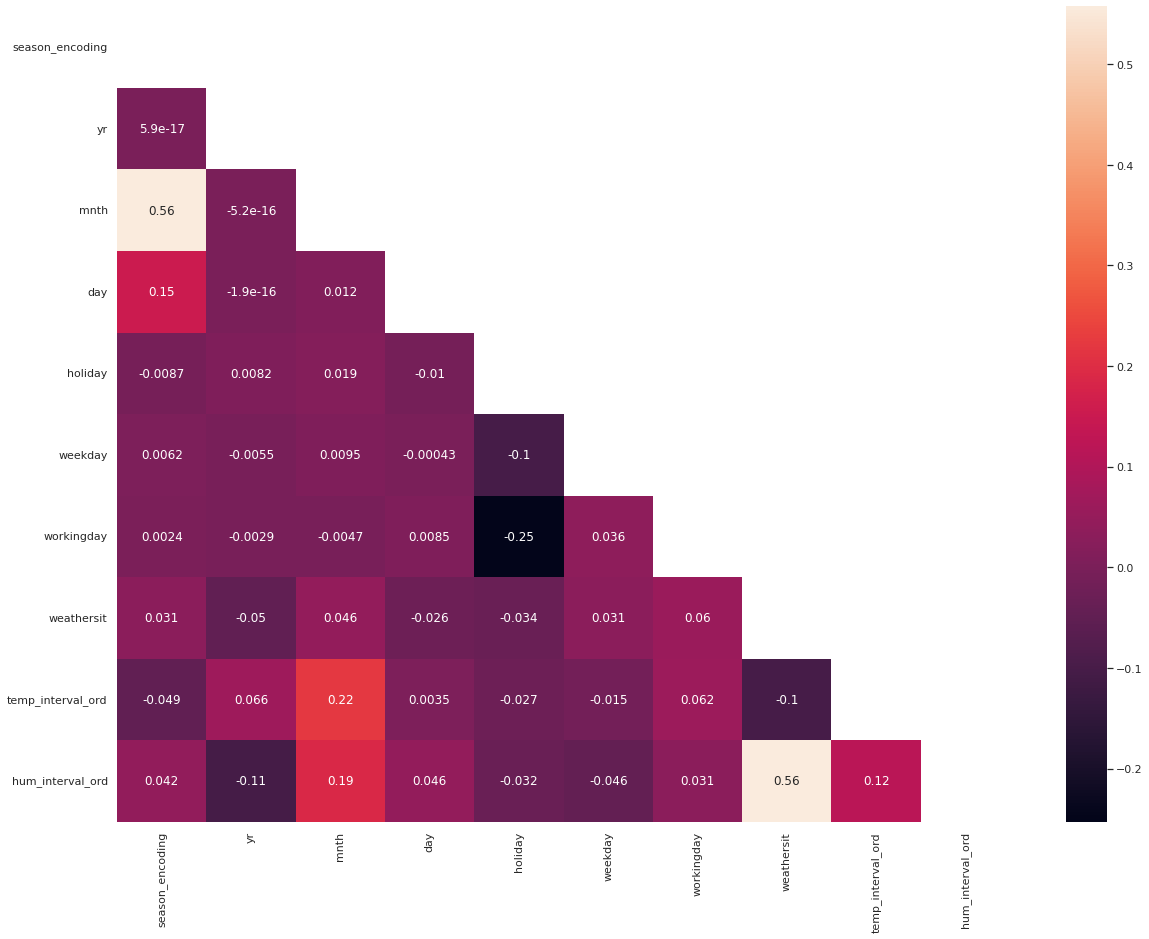

In [110]:
fig, ax = plt.subplots(figsize = (20,15))
corr = df_encoded.drop(columns = ['casual','registered','cnt']).corr() 
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot= True )

<font color="purple"> Deducimos que las variables están poco correlacionadas entre sí, por lo que de mometo las dejamos todas. Ojo! ¿Será que hay algo mal? porque season encoding tal vez debería relacionarse más con month

- Covarianza variables independientes (nos sirve solo para saber el sentido relación)

In [116]:
df_encoded.drop(columns = ['casual','registered','cnt']).cov() 

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord
season_encoding,1,0,2,1,-0,0,0,0,-0,0
yr,0,0,-0,0,0,-0,-0,-0,0,-0
mnth,2,-0,12,0,0,0,-0,0,1,0
day,1,0,0,77,-0,-0,0,-0,0,0
holiday,-0,0,0,-0,0,-0,-0,-0,-0,-0
weekday,0,-0,0,-0,-0,4,0,0,-0,-0
workingday,0,-0,-0,0,-0,0,0,0,0,0
weathersit,0,-0,0,-0,-0,0,0,0,-0,0
temp_interval_ord,-0,0,1,0,-0,-0,0,-0,1,0
hum_interval_ord,0,-0,0,0,-0,-0,0,0,0,1


- Correlación variables Dependientes o Predictoras

In [ ]:
df_encoded.head()

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord,wind_num_encoding,casual,registered,cnt
0,1,0,1,1,0,6,0,2,2,5,1,331,654,985
1,1,0,1,2,0,0,0,2,2,4,2,131,670,801
2,1,0,1,3,0,1,1,1,1,3,2,120,1229,1349
3,1,0,1,4,0,2,1,1,1,4,1,108,1454,1562
4,1,0,1,5,0,3,1,1,2,3,1,82,1518,1600


<AxesSubplot:>

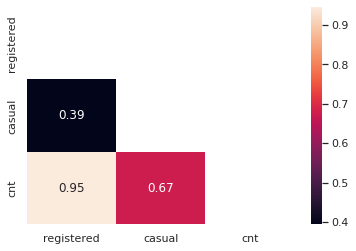

In [92]:
fig, ax = plt.subplots(figsize = (6,4))
corr = df_encoded[["registered", "casual", "cnt"]].corr() 
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot= True )

- Anova

In [127]:
lm_cnt = ols('cnt ~ season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp_interval_ord + hum_interval_ord + wind_num_encoding', data=df).fit()
sm.stats.anova_lm(lm_cnt)

,df,sum_sq,mean_sq,F,PR(>F)
wind_num_encoding,4,163392424,40848106,46,0
season_encoding,1,22673,22673,0,1
yr,1,887573213,887573213,1009,0
mnth,1,234008470,234008470,266,0
day,1,180395,180395,0,1
holiday,1,16648746,16648746,19,0
weekday,1,10251806,10251806,12,0
workingday,1,5988980,5988980,7,0
weathersit,1,203047978,203047978,231,0
temp_interval_ord,1,578636214,578636214,658,0


In [ ]:
lm_cnt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     170.9
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          5.09e-217
Time:                        21:33:32   Log-Likelihood:                -6024.0
No. Observations:                 730   AIC:                         1.208e+04
Df Residuals:                     715   BIC:                         1.215e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       1575.1782    239.037      6.590      0.000    1105.879    2044.477
wind_num_encoding[T.2]            76.7575     86.549      0.887      0.375     -93.164     246.679
wind_num_encoding[T.3]          -761.0958    146.421     -5.198      0.000   -1048.562    -473.630
wind_num_encoding[T.very_high]  -864.2909    363.097     -2.380      0.018   -1577.154    -151.428
wind_num_encoding[T.very_low]    441.8796     99.577      4.438      0.000     246.381     637.378
season_encoding                 -167.8001     52.585     -3.191      0.001    -271.040     -64.560
yr                              2040.1786     70.448     28.960      0.000    1901.869    2178.488
mnth                             113.4838     13.176      8.613      0.000      87.615     139.352
day                               -3.6350      4.032     -0.901      0.368     -11.552       4.282
holiday                         -637.2645    215.973     -2.951      0.003   -1061.281    -213.248
weekday                           74.4881     17.509      4.254      0.000      40.113     108.863
workingday                       123.8189     77.499      1.598      0.111     -28.333     275.971
weathersit                      -707.3303     80.469     -8.790      0.000    -865.314    -549.346
temp_interval_ord                820.3530     31.938     25.686      0.000     757.649     883.057
hum_interval_ord                -126.0953     60.127     -2.097      0.036    -244.141      -8.049
==============================================================================
Omnibus:                       30.723   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.387
Skew:                          -0.420   Prob(JB):                     4.62e-09
Kurtosis:                       3.746   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_reg = ols('registered ~ season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp_interval_ord + hum_interval_ord + wind_num_encoding', data=df).fit()
sm.stats.anova_lm(lm_reg) # vamos a obviar esta variable dependiente porque está muy correlacionada con 'cnt' y 

,df,sum_sq,mean_sq,F,PR(>F)
wind_num_encoding,4.0,8.939514e+07,2.234878e+07,42.019649,1.144892e-31
season_encoding,1.0,1.850188e+06,1.850188e+06,3.478679,6.257376e-02
yr,1.0,6.286011e+08,6.286011e+08,1181.880756,1.236237e-153
mnth,1.0,1.522606e+08,1.522606e+08,286.276705,2.892905e-54
day,1.0,1.124122e+04,1.124122e+04,0.021135,8.844515e-01
holiday,1.0,2.496966e+07,2.496966e+07,46.947349,1.574878e-11
weekday,1.0,3.816088e+06,3.816088e+06,7.174918,7.562859e-03
workingday,1.0,1.463867e+08,1.463867e+08,275.232849,1.546710e-52
weathersit,1.0,1.111164e+08,1.111164e+08,208.918378,9.904001e-42
temp_interval_ord,1.0,2.335199e+08,2.335199e+08,439.058547,2.246278e-76


In [ ]:
lm_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     187.1
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          6.14e-228
Time:                        21:33:19   Log-Likelihood:                -5840.5
No. Observations:                 730   AIC:                         1.171e+04
Df Residuals:                     715   BIC:                         1.178e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        933.5529    185.897      5.022      0.000     568.584    1298.521
wind_num_encoding[T.2]            23.9055     67.308      0.355      0.723    -108.240     156.051
wind_num_encoding[T.3]          -552.8007    113.870     -4.855      0.000    -776.360    -329.242
wind_num_encoding[T.very_high]  -441.9956    282.376     -1.565      0.118    -996.381     112.390
wind_num_encoding[T.very_low]    277.7467     77.440      3.587      0.000     125.710     429.784
season_encoding                 -127.9523     40.895     -3.129      0.002    -208.241     -47.664
yr                              1752.8973     54.786     31.995      0.000    1645.336    1860.459
mnth                             108.6531     10.247     10.603      0.000      88.535     128.771
day                               -3.5671      3.136     -1.138      0.256      -9.724       2.590
holiday                         -339.3497    167.960     -2.020      0.044    -669.103      -9.597
weekday                           44.5311     13.616      3.270      0.001      17.798      71.264
workingday                       953.2410     60.270     15.816      0.000     834.914    1071.568
weathersit                      -556.4960     62.580     -8.893      0.000    -679.358    -433.634
temp_interval_ord                520.6860     24.838     20.963      0.000     471.922     569.450
hum_interval_ord                 -74.0853     46.760     -1.584      0.114    -165.888      17.718
==============================================================================
Omnibus:                       96.243   Durbin-Watson:                   0.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.123
Skew:                          -0.783   Prob(JB):                     1.41e-41
Kurtosis:                       4.932   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_casu = ols('casual ~ season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp_interval_ord + hum_interval_ord + wind_num_encoding', data=df).fit()
sm.stats.anova_lm(lm_casu)

,df,sum_sq,mean_sq,F,PR(>F)
wind_num_encoding,4.0,1.274284e+07,3.185711e+06,20.471339,5.522624e-16
season_encoding,1.0,1.463232e+06,1.463232e+06,9.402714,2.248302e-03
yr,1.0,2.228075e+07,2.228075e+07,143.175794,3.322089e-30
mnth,1.0,8.749432e+06,8.749432e+06,56.223744,1.919979e-13
day,1.0,1.015725e+05,1.015725e+05,0.652704,4.194164e-01
holiday,1.0,8.402969e+05,8.402969e+05,5.399737,2.041924e-02
weekday,1.0,1.558410e+06,1.558410e+06,10.014326,1.619102e-03
workingday,1.0,9.315723e+07,9.315723e+07,598.627244,1.603947e-96
weathersit,1.0,1.375160e+07,1.375160e+07,88.367592,7.189860e-20
temp_interval_ord,1.0,7.697431e+07,7.697431e+07,494.635944,1.079715e-83


In [ ]:
lm_casu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     106.6
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          2.71e-164
Time:                        21:35:20   Log-Likelihood:                -5391.9
No. Observations:                 730   AIC:                         1.081e+04
Df Residuals:                     715   BIC:                         1.088e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        641.6254    100.554      6.381      0.000     444.208     839.042
wind_num_encoding[T.2]            52.8519     36.408      1.452      0.147     -18.628     124.332
wind_num_encoding[T.3]          -208.2951     61.594     -3.382      0.001    -329.222     -87.369
wind_num_encoding[T.very_high]  -422.2953    152.742     -2.765      0.006    -722.171    -122.420
wind_num_encoding[T.very_low]    164.1329     41.888      3.918      0.000      81.894     246.372
season_encoding                  -39.8478     22.121     -1.801      0.072     -83.277       3.582
yr                               287.2813     29.635      9.694      0.000     229.100     345.463
mnth                               4.8307      5.543      0.872      0.384      -6.051      15.713
day                               -0.0678      1.696     -0.040      0.968      -3.398       3.262
holiday                         -297.9148     90.852     -3.279      0.001    -476.283    -119.546
weekday                           29.9569      7.365      4.067      0.000      15.497      44.417
workingday                      -829.4221     32.601    -25.442      0.000    -893.427    -765.417
weathersit                      -150.8343     33.850     -4.456      0.000    -217.292     -84.376
temp_interval_ord                299.6670     13.435     22.305      0.000     273.290     326.044
hum_interval_ord                 -52.0100     25.293     -2.056      0.040    -101.668      -2.352
==============================================================================
Omnibus:                       61.303   Durbin-Watson:                   1.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.303
Skew:                           0.584   Prob(JB):                     1.01e-22
Kurtosis:                       4.402   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font color = "purple" > Deducimos que cnt y registered están muy correlacionadas, por lo que habrá que tenerlo en cuenta cuando hagamos los modelos.

<font color = "purple" > El mejor modelo predictivo para nosotras con todas las v. ind y la v. dep `registered` y `cnt` (recuerda que tiene sentido pq están correlacionadas)

<font color = 'purple'> Ahora tenemos que ver que se cumplen las asunciones de la ANOVA para ver si nuestra anova DICE LA VERDAD y NOS PODEMOS FIAR DE ELLA.

- Comprobación asunciones de ANOVA: normalidad, homocedasticidad, independencia

    normalidad: shapiro

- Comprabamos normalidad

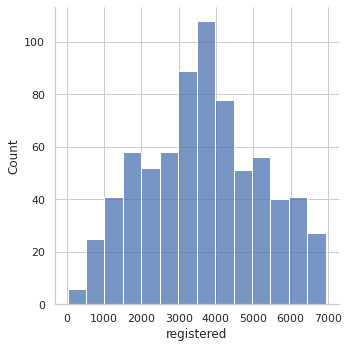

In [97]:
sns.displot(df["registered"])

In [93]:
#Hacemos de nuevo el shapiro a ver si lo hemos normalizado
stats.shapiro (df["registered"])

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

In [103]:
df_encoded["registered"],lambda_ajustada= stats.boxcox(df["registered"])

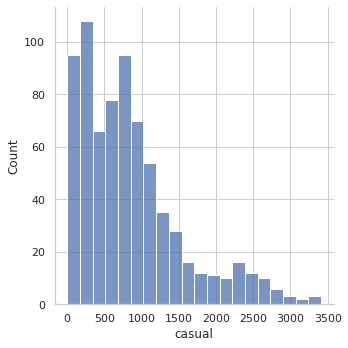

In [99]:
sns.displot(df["casual"])

In [100]:
stats.shapiro (df["casual"])

ShapiroResult(statistic=0.8850967288017273, pvalue=7.660028716313278e-23)

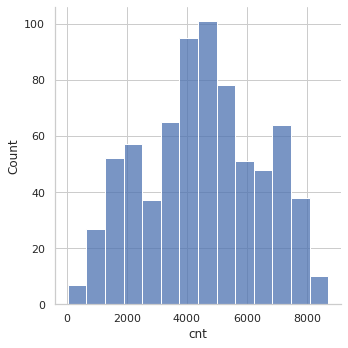

In [101]:
sns.displot(df["cnt"])

In [102]:
stats.shapiro (df["cnt"])

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

- Transformamos para que sean normales

In [117]:
# Si no son normales podemos transformar por : LOG, RAIZ CUADRADA Y BOX COX(
df_encoded["cnt"],lambda_ajustada= stats.boxcox(df["cnt"])
df_encoded["registered"],lambda_ajustada= stats.boxcox(df["registered"])
df_encoded["casual"],lambda_ajustada= stats.boxcox(df["casual"])

<font color= purple> Me quedo, aquí! falta revisar homocedasticdad e indepencia. Atenta! hay que separar numéricas y categóricas?

- Otra asunción ANOVA: homocedasticidad

In [128]:
# # Aquí comienza la resolucion del ejercicio 1
# residuals = (y_test - y_prediction)


# # 2. Independencia

# fig,ax = plt.subplots(figsize= (8,4))
# plt.scatter(x=y_test , y=residuals)
# plt.axline((float(min(y_prediction)),0),(float(max(y_prediction)),0),color="black",linestyle= '--') 
# plt.title('Gráfica de dispersion de dos conjuntos de datos')
# ax.set_xlabel('Longitud del sépalo conjunto test')
# ax.set_ylabel('Residuos')
# plt.show()


# # 3. Homocedasticidad

# fig,ax = plt.subplots(figsize= (8,4))
# plt.scatter(x=y_prediction , y=residuals)
# plt.axline((float(min(y_prediction)),0),(float(max(y_prediction)),0),color="black",linestyle= '--') 
# plt.title('Gráfica de dispersion de dos conjuntos de datos')
# ax.set_xlabel('Longitud del sépalo conjunto test predicho')
# ax.set_ylabel('Residuos')
# plt.show()

# # 4. Normalidad
# # preprocessing.normalize()
# fig = plt.figure()
# sns.distplot(residuals,bins = len(residuals))
# plt.show()
# sm.qqplot(residuals, line = '45', fit = True)
# py.show()

    homocedasticidad :  test levene

    pvalor < 0,05 NO SIGNIFICATIVO, CUMPLE ASUNCIÓN , TIENEN VARIANZAS SIMILARES
    P valor > 0,05 SIGNIFICATIVO , no cumple asunción, NO TIENEN VARIANZAS SIMILARES

    

In [ ]:
#se aplica a categoricas y numericas
#primera categoricas

fig,axes = plt.subplots(1,4,figsize =(30,10))

axes= axes.flat

colum_cat= df_encoded.select_dtypes(include=["object", "category"]).columns

for i,col in enumerate(colum_cat):
    sns,boxplot(
        x= col,
        y= "cnt",
        data= df_bike,
        palette= "tab10",
        ax= axes[i]
    )

In [ ]:
def datos_test_levene(columan,df):
    valoresr=df[columna].unique()
    d= {}

for x in valroes:
    d[x]= df[df(columna) == x]["cnt"]

Aqui nos saca los diferentes Dataframes

In [ ]:
sexo= detectar_test_levene("temperatura",df) #esta sobre la categorica creada low, high,...
smoker= detectar_test_levene("viento",df)
region= detectar_test_levene("humedad",df)
hijos= detectar_test_levene("season",df)

Ahora comprobamos levene para estos Df

In [ ]:
stats.levene(temperatura[0], temperatura[1], temperatura[2], temperatura[3], center = "median")
stats.levene(viento["low"], viento["high"], viento["2"], viento["3"], center = "median")
stats.levene(humedad["low"], humedad["high"], humedad["2"], humedad["3"], center = "median")
stats.levene(season["low"], season["high"], season["2"], season["3"], center = "median")

#ejemplo
levene_hijos = stats.levene(hijos['1'], hijos['2'], hijos['3'], hijos['4'], hijos['5'],  center='median')
levene_hijos

¿Cuantas de las variables categoricas cumplen homo? SI son todas genial, si no son todas, hay algunas hetero, estas hetero no deberiamos incluirlas en regresion lineal. Las ELIMINAMOS DEL DF, que vamos a presentar a la regresion.
Si solo tienes 1 homo, puedes plantear cambiar de modelo.

HOmocedasticidad PARA NUMERICAS

In [ ]:
numericas.head()

In [ ]:
# iniciamos los subplots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

# definimos una lista de colores. Cada color corresponderá a una gráfica
lista_colores = ["cadetblue", "seagreen"]

# hemos creado una gráfica con varios subplots. Si queremos automatizar el proceso de relleno de cada uno de los plots
## podemos usar el método .flat. Lo que hace es aplanar los ejes para que queden en una única dimensión
## y luego los vamos rellenando. 
axes = axes.flat

# seleccionamos las columnas que queremos graficar
columnas_numeric = df.select_dtypes(include = np.number).drop('charges', axis=1)
columnas_numeric = columnas_numeric.columns

# iniciamos un for loop para no tener que escribir la misma línea de código muchas veces
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = df,
        x = colum,
        y = 'charges',
        color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])

fig.tight_layout();

#¿Como vemos con este grafico las variables numericas, son homocedasticas?
#Todos los puntos deben estar alrededor de ma media Y = 0, tanto por arriba como por abajo. SON HOMOCEDASTICOS
#Si es tipo enbudo NO SON HOMOCEDASTICOS

In [ ]:
numericas.head()

In [ ]:
resultados= {}

numer= numericas.columns.drop(["children","charges"]) #hemos quitado esta por que ya es categorica

for col in numer:
    stat,p_value = levene(df[col], df.charges,center="median")

    resultados[col]= p_value

In [ ]:
resultados # aqui nos da los resutlados y podemos ver si son o no Homo

- Otra asunción ANOVA: independencia

    Asuncion de independencia

    -
     MIS DATOS DEBEN SER INDEPENDIENTES ENTRE ELLOS (ES LO QUE BUSCAMOS)  chi- Cuadrado
     comparamos cnt(respuesta) con cada una de las variables independientes.

     PVALUE> 0,05 NUESTRAS VARIABLES SON INDEPENDIENTES
     PVALUE< 0,05 NO SON INDEPENDIENTES

     CRAMER TE DICE SI SON FUERTES O DEBILES  CERCA DE 0,6 ES FUERTE - 0,2 ES DEBIL

In [122]:
columnas = df_encoded.columns
columnas

Index(['season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp_interval_ord', 'hum_interval_ord',
       'wind_num_encoding', 'casual', 'registered', 'cnt'],
      dtype='object')

In [ ]:
combinaciones= list(itertools.combinations(columnas,2))#combinaciones de 2 en dos
combinaciones #te las da sin repeticion

In [126]:
for par in combinaciones:
    crosstab,test_result, expected= rp.crosstab(df[par[0]],df[par[1]],
                                                test= "chi-square",
                                                expected_freqs=True,
                                                prop= "cell")

print("----------------", par[0]," + " , par[1],"-------------------")
print(test_result)

# AQUI VAMOS A VER QUIENES SON INDEPENDIENTES Y QUIENES NO
#¿QUE HACEMOS CON ELLAS? LAS QUITAMOS DEL MODELO O LAS TRANSFORMAMOS ¿TIENE SENTIDO? PERDEMOS SENTIDO EN NUESTRO DATASET

---------------- registered  +  cnt -------------------
                     Chi-square test  results
0  Pearson Chi-square ( 469838.0) =    470668
1                         p-value =         0
2                      Cramer's V =         1


    ANOVA lo hacemos para ver nivel de significancia de mi variable respuesta, con las independientes.
    #Vamos a meter todas variables y para comprobar quien tiene mucho significado

In [ ]:
ls= ols("charge - sex + bmi + children",data=df).fit()
sm.stats.anova_lm(ls)

ls.summary() # esto es lo importante  R-square-

# miro R.square : 0.111,...esto es la % de probabilidad que tiene este conjunto de variables independientes
#  de contestar a mi variable respuesta

# si pvalor< 0,05 entonces es significativa para la prediccion 
# OJO al intercept que es el punto de referencia. Va a coger por orden alfabeticos de las variables categoricas.

#¿Que informacion importante?
#coef podemos ver como la intensidad en la que influye
#pvalor < 0,05

    HACER VIF

In [ ]:
VIF

# cercano a 1 no hay relación
# de 1 a 5 relación moderada
# mas de 5 fuerte relacion

### REGRESION MULTIPLE LINEAL: QUEREMOS SABER EL NUMERO TOTAL DE RESERVAS DE BICIS Y SI LAS VARIABLES INDEPENDIENTES, NOS AYUDAN A CONOCERLO Y EN QUE MEDIDA, SEGÚN LA RESPUESTA DEL MODELO.

In [ ]:
x =df_numericas.drop(columns = ['cnt','registered', 'casual' ]) #Quitamos nuestra variable dependiente.
y = df_numericas['cnt']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression()
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

In [ ]:
y_pred_test.reset_index(inplace=True) # Se me crea nueva columna y luego la dropeo

    FORMA DE ANA

In [ ]:
x =df_numericas.drop(columns = ['cnt','registered', 'casual' ]) #Quitamos nuestra variable dependiente.
y = df_numericas['cnt']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression()
# Ajustamos el modelo
LR.fit(x_train,y_train)

In [ ]:
#obligatorio definir antes para la fincion
y_prep_test= lr.predict(x_test)
y_prep_train = lr.predict(x_train)

In [ ]:
def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

    #nos fijamos en el rmse y rcuadrado
    #RMSE es cuanto me equivoco

In [ ]:
result= metricas(y_test,y_train,y_pred_train,y_pred_test ) # y me dice los resultados de train y test
#el RMSE puede ser positivo o negativo en funcion del problema, hay que mirar con un describe max y min
result

In [ ]:
results.style.background_gradient(cmap="coolwarm") # te da de colores DF

In [ ]:
#¿Cuando ocurre overfiting? Cuando se ha aprendido de memoria mis datos

#cuando las metricas en en train sean mucho mejores que en test rcuadrados altos y rmse bajos
#underfiting lo contrario
#ambas es que hay un modelo predictivo basura

# se soluciona añadiendo variables predictoras (aprende a coser con una prenda, o aprende con muchas prendas)
#over mas datos y menos variables predictoras
#under mas filas en nuestro df y mas variables predictoras

#no queremos ninguno de los dos

UNA VEZ QUE CONOZCAMOS ESTOS DATOS, PODEMOS VER SI PODRIAN MEJORAR Y DEBEMOS ESTANDARIZAR Y PROBAR DE NUEVO